In [1]:
import re

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Grocery Sales: Forecasting demand and optimizing price

This notebook details the work done as a preliminary analysis to understand the sales of fresh vegetables at a Chinese supermarket.

Starting from a first look at the data to the preparation of the data for modeling.

In [2]:
# generalized utility functions

def create_rename_map(frame:pd.DataFrame) -> dict:
    return {col: re.sub(' ', '_',col.lower().split(' (')[0]) for col in frame.columns.tolist()}

def label_figure(ax, spacing=5):
    for rect in ax.patches:
        y_val = rect.get_height()
        x_val = rect.get_x() + rect.get_width() /2
        space = spacing
        va = 'bottom'
        if y_val < 0:
            space*= -1
            va = 'top'
        label = '{:.2f}'.format(y_val)
        ax.annotate(
            label,
            (x_val,y_val),
            xytext = (0,space),
            textcoords='offset points',
            ha = 'center',
            va=va            
        )

import datasets

We want to create mappings between the Item codes and the Item names. We want to 

In [3]:
name_data = pd.read_csv('annex1.csv')
sales_data = pd.read_csv('annex2.csv')
cost_data = pd.read_csv('annex3.csv')
loss_data = pd.read_csv('annex4.csv')

In [4]:
# rename columns in dataset for ease of use
nd_dict = create_rename_map(name_data)
sd_dict = create_rename_map(sales_data)
cd_dict = create_rename_map(cost_data)
ld_dict = create_rename_map(loss_data)

name_data.rename(columns=nd_dict,inplace=True)
sales_data.rename(columns=sd_dict, inplace=True)
cost_data.rename(columns=cd_dict, inplace=True)
loss_data.rename(columns=ld_dict, inplace=True)

In [5]:
sd_dict

{'Date': 'date',
 'Time': 'time',
 'Item Code': 'item_code',
 'Quantity Sold (kilo)': 'quantity_sold',
 'Unit Selling Price (RMB/kg)': 'unit_selling_price',
 'Sale or Return': 'sale_or_return',
 'Discount (Yes/No)': 'discount'}

In [6]:
cd_dict

{'Date': 'date',
 'Item Code': 'item_code',
 'Wholesale Price (RMB/kg)': 'wholesale_price'}

In [7]:
ld_dict

{'Item Code': 'item_code',
 'Item Name': 'item_name',
 'Loss Rate (%)': 'loss_rate'}

## retaining units:

For future reference we have the following units attached to numerical values:

- quantity_sold: kg (hundredths)
- (unit_selling/wholesale)_price: rmb/kg
- loss_rate: percentage

## Assumptions:

All product sold in a given month was purchased in the same month.

- This is going to be useful when determining the total amount of purchased product from suppliers for a given month

In [8]:
sales_data.head()

,date,time,item_code,quantity_sold,unit_selling_price,sale_or_return,discount
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No


In [9]:
name_data.head()

,item_code,item_name,category_code,category_name
0,102900005115168,Niushou Shengcai,1011010101,Flower/Leaf Vegetables
1,102900005115199,Sichuan Red Cedar,1011010101,Flower/Leaf Vegetables
2,102900005115625,Local Xiaomao Cabbage,1011010101,Flower/Leaf Vegetables
3,102900005115748,White Caitai,1011010101,Flower/Leaf Vegetables
4,102900005115762,Amaranth,1011010101,Flower/Leaf Vegetables


In [10]:
name_data['in_trunc'] = name_data['item_name'].str.split('(').apply(lambda x: x[0].lower().strip())
name_data['min_ic'] = name_data.groupby('in_trunc')['item_code'].transform('min')

In [11]:
name_data['suffix'] = name_data['item_name'].str.split('(').apply(lambda x: ' '.join(x[1:]).lower().strip()).str.replace(')','',regex=False)

In [12]:
name_data

,item_code,item_name,category_code,category_name,in_trunc,min_ic,suffix
0,102900005115168,Niushou Shengcai,1011010101,Flower/Leaf Vegetables,niushou shengcai,102900005115168,
1,102900005115199,Sichuan Red Cedar,1011010101,Flower/Leaf Vegetables,sichuan red cedar,102900005115199,
2,102900005115625,Local Xiaomao Cabbage,1011010101,Flower/Leaf Vegetables,local xiaomao cabbage,102900005115625,
3,102900005115748,White Caitai,1011010101,Flower/Leaf Vegetables,white caitai,102900005115748,
4,102900005115762,Amaranth,1011010101,Flower/Leaf Vegetables,amaranth,102900005115762,
...,...,...,...,...,...,...,...
246,106958851400125,Haixian Mushroom (Bag) (4),1011010801,Edible Mushroom,haixian mushroom,102900005119944,bag 4
247,106971533450003,Haixian Mushroom (Bunch),1011010801,Edible Mushroom,haixian mushroom,102900005119944,bunch
248,106971533455008,Haixian Mushroom (Bag) (3),1011010801,Edible Mushroom,haixian mushroom,102900005119944,bag 3
249,106973223300667,Chinese Caterpillar Fungus Flowers (Box) (2),1011010801,Edible Mushroom,chinese caterpillar fungus flowers,102900011011782,box 2


In [13]:
pd.merge(
    cost_data[cost_data['date'] == '2021-07-01'],
    name_data,
    how = 'left',
    left_on='item_code',
    right_on='item_code'
).groupby('min_ic').agg({'wholesale_price':list,'item_name':pd.unique})

,wholesale_price,item_name
min_ic,,
102900005115762,[1.81],[Amaranth]
102900005115779,[4.9],[Yunnan Shengcai]
102900005115786,[2.22],[Zhuyecai]
102900005115793,"[9.22, 1.5]",[Chinese Cabbage]
102900005115823,[3.94],[Shanghaiqing]
102900005115908,[3.91],[Caixin]
102900005115946,[3.1],[Muercai]
102900005115984,[3.02],[Yunnan Lettuces]
102900005116219,[3.27],[Red Hot Peppers]


Looking at a subset of the data joined and reduced we see that there are some pricing discrepancies. I am going to be doing a major join first to create the cost column. This is going to be done after aggregating the data to the monthly level. 

prior to this I am going to do some investigation into DoW and HoD sales data.

In [14]:
sales_data.isna().sum()

date                  0
time                  0
item_code             0
quantity_sold         0
unit_selling_price    0
sale_or_return        0
discount              0
dtype: int64

In [15]:
sales_data['date_time'] = pd.to_datetime(sales_data.apply(lambda row: f'{row.date} {row.time}', axis=1))

In [17]:
sales_data.sale_or_return.value_counts(normalize=True)

sale      0.999475
return    0.000525
Name: sale_or_return, dtype: float64

In [18]:
sales_data['discount'].value_counts(normalize=True)

No     0.946083
Yes    0.053917
Name: discount, dtype: float64

Quickly looking into the sales data we see that of all of the sales only .005% of all transactions in the dataset are returns. That to me signals that any amount of waste that occurs in a given month is fairly minimal. I am also going to try and identify when these sales took place, were they made in error and credited back immediately?

Additionally we see that 95% of all of the sales were full priced, while 5% were discounted.

In [20]:
sales_data['hour'] = sales_data.date_time.dt.hour

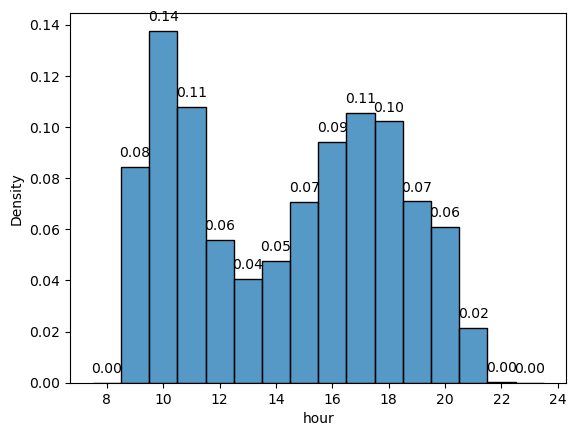

In [21]:
fig = sns.histplot(
    data=sales_data,
    x='hour',
    binwidth=1,
    stat='density',
    discrete=True
)

label_figure(fig)

plt.show()

In [22]:
merged = pd.merge(
    sales_data,
    name_data,
    how='left',
    left_on='item_code',
    right_on='item_code'
)

In [23]:
merged = pd.merge(
    merged,
    cost_data,
    how='left',
    left_on=['date','item_code'],
    right_on=['date','item_code']
)

In [24]:
merged['profit'] = merged['quantity_sold'] * (merged['unit_selling_price'] - merged['wholesale_price'])

In [25]:
merged

,date,time,item_code,quantity_sold,unit_selling_price,sale_or_return,discount,date_time,hour,item_name,category_code,category_name,in_trunc,min_ic,suffix,wholesale_price,profit
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No,2020-07-01 09:15:07.924,9,Paopaojiao (Jingpin),1011010504,Capsicum,paopaojiao,102900005117056,jingpin,4.32,1.29888
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No,2020-07-01 09:17:27.295,9,Chinese Cabbage,1011010101,Flower/Leaf Vegetables,chinese cabbage,102900005115793,,2.10,0.93390
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No,2020-07-01 09:17:33.905,9,Paopaojiao (Jingpin),1011010504,Capsicum,paopaojiao,102900005117056,jingpin,4.32,1.34152
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No,2020-07-01 09:19:45.450,9,Shanghaiqing,1011010101,Flower/Leaf Vegetables,shanghaiqing,102900005115823,,7.03,1.25037
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No,2020-07-01 09:20:23.686,9,Caixin,1011010101,Flower/Leaf Vegetables,caixin,102900005115908,,4.60,1.83260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878498,2023-06-30,21:35:13.264,102900005115250,0.284,24.0,sale,No,2023-06-30 21:35:13.264,21,Xixia Black Mushroom (1),1011010801,Edible Mushroom,xixia black mushroom,102900005115250,1,15.60,2.38560
878499,2023-06-30,21:35:14.358,102900011022764,0.669,12.0,sale,No,2023-06-30 21:35:14.358,21,Changxianqie,1011010501,Solanum,changxianqie,102900011022764,,7.00,3.34500
878500,2023-06-30,21:35:20.264,102900005115250,0.125,24.0,sale,No,2023-06-30 21:35:20.264,21,Xixia Black Mushroom (1),1011010801,Edible Mushroom,xixia black mushroom,102900005115250,1,15.60,1.05000
878501,2023-06-30,21:35:21.509,102900011016701,0.252,5.2,sale,No,2023-06-30 21:35:21.509,21,Wuhu Green Pepper (1),1011010504,Capsicum,wuhu green pepper,102900011016701,1,3.63,0.39564


In [26]:
merged.isna().sum()

date                  0
time                  0
item_code             0
quantity_sold         0
unit_selling_price    0
sale_or_return        0
discount              0
date_time             0
hour                  0
item_name             0
category_code         0
category_name         0
in_trunc              0
min_ic                0
suffix                0
wholesale_price       0
profit                0
dtype: int64

Even after merging all of the data we still don't have any missing data

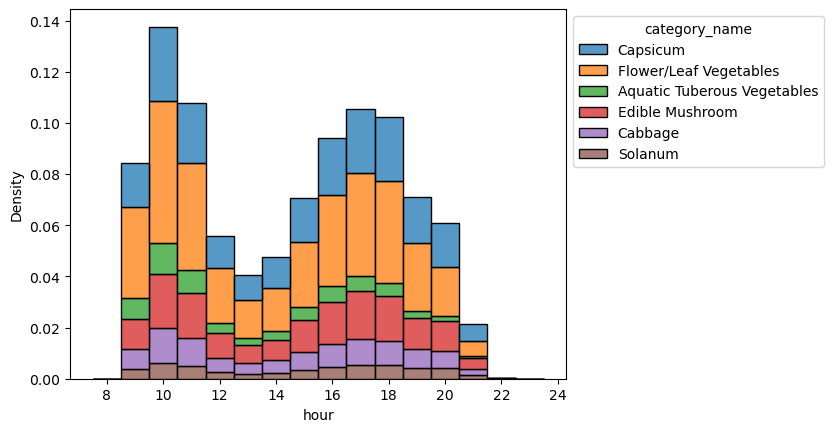

In [27]:
fig = sns.histplot(
    data=merged,
    x='hour',
    binwidth=1,
    stat='density',
    discrete=True,
    hue='category_name',
    multiple='stack'
)

#label_figure(fig)
sns.move_legend(fig,loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [28]:
merged.drop_duplicates('in_trunc', keep='first').category_name.value_counts(normalize=True)

Flower/Leaf Vegetables         0.478788
Edible Mushroom                0.218182
Capsicum                       0.169697
Aquatic Tuberous Vegetables    0.072727
Solanum                        0.036364
Cabbage                        0.024242
Name: category_name, dtype: float64

In [29]:
merged.category_name.value_counts(normalize=True)

Flower/Leaf Vegetables         0.377879
Capsicum                       0.236762
Edible Mushroom                0.168951
Cabbage                        0.098543
Aquatic Tuberous Vegetables    0.066758
Solanum                        0.051107
Name: category_name, dtype: float64

Here it is observed that the proportion of sales for different item categories differs slightly from the proportion of items within each category. We see that our leafy greens are predominately the highest selling item. We see a reversal between edible mushrooms and peppers, with peppers having higher sales than mushrooms even though there is a greater diversity of edible mushroom items.

These differences are likely due to the number of items being sold together in packs versus individually. 

In [30]:
tmp = merged.groupby([pd.Grouper(key='date_time', freq='D'),'category_name'])['quantity_sold'].sum().reset_index()

In [31]:
tmp

,date_time,category_name,quantity_sold
0,2020-07-01,Aquatic Tuberous Vegetables,4.850
1,2020-07-01,Cabbage,46.640
2,2020-07-01,Capsicum,76.715
3,2020-07-01,Edible Mushroom,35.365
4,2020-07-01,Flower/Leaf Vegetables,205.402
...,...,...,...
6469,2023-06-30,Cabbage,28.087
6470,2023-06-30,Capsicum,82.286
6471,2023-06-30,Edible Mushroom,39.572
6472,2023-06-30,Flower/Leaf Vegetables,130.464


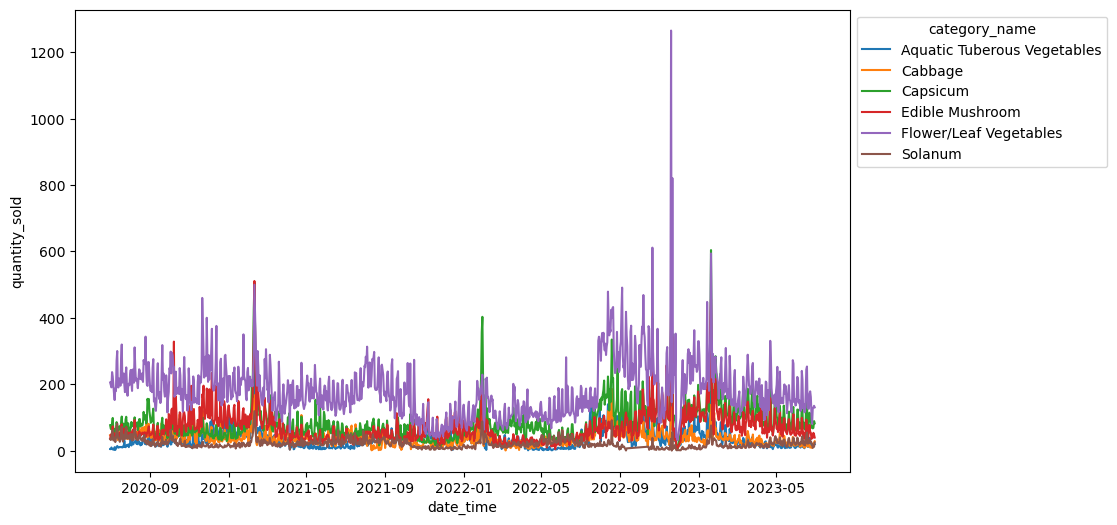

In [32]:
_, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(
    data = tmp,
    x='date_time',
    y='quantity_sold',
    hue='category_name',
    ax=ax
)
sns.move_legend(ax,loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [35]:
def plot_seasonal_decompose(dataframe, column_name, freq=365, figsize=(12, 8),model='additive'):
    """
    Decompose the time series data in the specified column of the DataFrame
    and plot the original, trend, seasonal, and residual components.
    
    Parameters:
        dataframe (pd.DataFrame): Input pandas DataFrame containing the time series data.
        column_name (str): Name of the column in the DataFrame containing the time series data.
        freq (int, optional): Frequency of the time series. Default is 365 for daily data.
        figsize (tuple, optional): Size of the output plot. Default is (12, 8).
        
    Returns:
        None (plots the figures).
    """
    # Extract the time series data from the specified column
    time_series = dataframe[column_name]
    
    # Perform seasonal decomposition
    result = seasonal_decompose(time_series, period=freq, model=model)
    
    # Plot the original, trend, seasonal, and residual components
    plt.figure(figsize=figsize)
    plt.subplot(411)
    plt.plot(time_series, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    return result

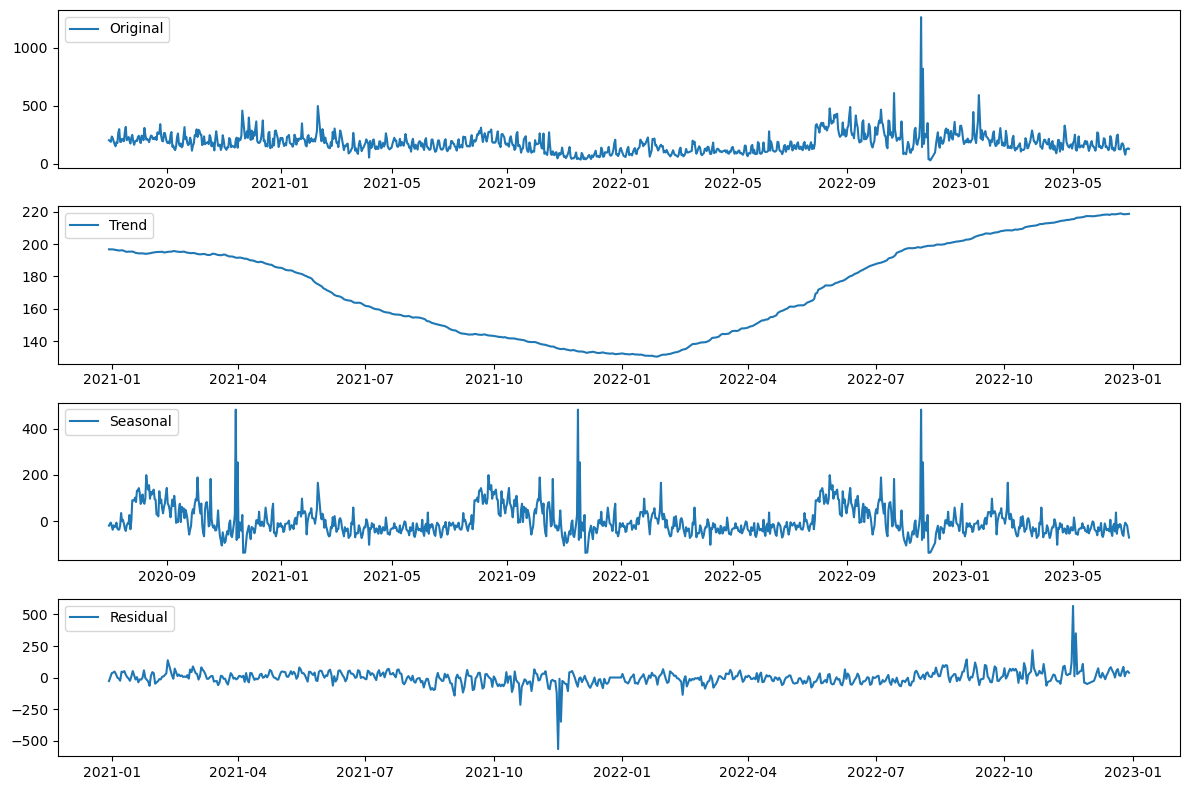

In [44]:
res_1 = plot_seasonal_decompose(
    dataframe=tmp[tmp['category_name']=='Flower/Leaf\xa0Vegetables'].set_index('date_time'),
    column_name='quantity_sold',
    freq=365,
    model='additive'
    )

In [45]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def run_tests(timeseries):
    kpss_test(timeseries=timeseries)
    print()
    adf_test(timeseries=timeseries)

In [46]:
run_tests(tmp[tmp['category_name']=='Flower/Leaf\xa0Vegetables'].set_index('date_time')['quantity_sold'].diff().dropna())

Results of KPSS Test:
Test Statistic            0.048263
p-value                   0.100000
Lags Used                82.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -1.177003e+01
p-value                        1.095529e-21
#Lags Used                     2.000000e+01
Number of Observations Used    1.063000e+03
Critical Value (1%)           -3.436517e+00
Critical Value (5%)           -2.864263e+00
Critical Value (10%)          -2.568220e+00
dtype: float64


/tmp/ipykernel_115895/160048533.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Looking at the sale data for the different vegetable categories we see that there are several different periods of seasonality present within the data. Looking at the hourly level we see patterns in the purchase hours that seem to indicate when restaurants and individuals are much more likely to be purchasing their goods. We see a large spike in the more accounting for over 30% of the sales that tapers off from about noon - two pm. Then we see a secondary peak that would correspond with individuals getting off from work and going home to cook dinner for themselves.

OR SO I AM concluding.

At the daily level we see yearly trends that happen to correspond with peak growing/harvesting season for crops as well as massive spikes corresponding with Lunar New Year.

Next step: I am going to be looking at individual products at the daily level, and look into predicting sales volumes.

In [191]:
pd.merge(
    pd.Series(pd.date_range(tmp['date_time'].min(), tmp['date_time'].max()), name='date'),
    pd.Series(merged['item_code'].unique(),name='item_code'),
    how='cross'
)

,date,item_code
0,2020-07-01,102900005117056
1,2020-07-01,102900005115960
2,2020-07-01,102900005115823
3,2020-07-01,102900005115908
4,2020-07-01,102900005115779
...,...,...
269365,2023-06-30,102900011036242
269366,2023-06-30,102900011035849
269367,2023-06-30,102900011021675
269368,2023-06-30,106972776821582


In [57]:
merged.sort_values(by = ['date','time'], ascending = [1,1], inplace = True)

Looking at the data it appears that we can group items together to get a sense of what things are bought together and at what times of day.

In [58]:
merged

,date,time,item_code,quantity_sold,unit_selling_price,sale_or_return,discount,date_time,hour,item_name,category_code,category_name,in_trunc,min_ic,suffix,wholesale_price,profit
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No,2020-07-01 09:15:07.924,9,Paopaojiao (Jingpin),1011010504,Capsicum,paopaojiao,102900005117056,jingpin,4.32,1.29888
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No,2020-07-01 09:17:27.295,9,Chinese Cabbage,1011010101,Flower/Leaf Vegetables,chinese cabbage,102900005115793,,2.10,0.93390
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No,2020-07-01 09:17:33.905,9,Paopaojiao (Jingpin),1011010504,Capsicum,paopaojiao,102900005117056,jingpin,4.32,1.34152
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No,2020-07-01 09:19:45.450,9,Shanghaiqing,1011010101,Flower/Leaf Vegetables,shanghaiqing,102900005115823,,7.03,1.25037
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No,2020-07-01 09:20:23.686,9,Caixin,1011010101,Flower/Leaf Vegetables,caixin,102900005115908,,4.60,1.83260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878498,2023-06-30,21:35:13.264,102900005115250,0.284,24.0,sale,No,2023-06-30 21:35:13.264,21,Xixia Black Mushroom (1),1011010801,Edible Mushroom,xixia black mushroom,102900005115250,1,15.60,2.38560
878499,2023-06-30,21:35:14.358,102900011022764,0.669,12.0,sale,No,2023-06-30 21:35:14.358,21,Changxianqie,1011010501,Solanum,changxianqie,102900011022764,,7.00,3.34500
878500,2023-06-30,21:35:20.264,102900005115250,0.125,24.0,sale,No,2023-06-30 21:35:20.264,21,Xixia Black Mushroom (1),1011010801,Edible Mushroom,xixia black mushroom,102900005115250,1,15.60,1.05000
878501,2023-06-30,21:35:21.509,102900011016701,0.252,5.2,sale,No,2023-06-30 21:35:21.509,21,Wuhu Green Pepper (1),1011010504,Capsicum,wuhu green pepper,102900011016701,1,3.63,0.39564


In [132]:
merged_daily = merged[merged.sale_or_return == 'sale'].groupby(['item_code',pd.Grouper(key='date_time', freq='D')]).agg(
    quantity = ('quantity_sold','sum'),
    profit = ('profit','sum'),
    avg_price = ('unit_selling_price','mean'),
    avg_wholesale = ('wholesale_price','mean'),
    item_name = ('item_name','first'),
    item_name_trunc = ('in_trunc','first'),
    base_item_code = ('min_ic','first'),
    category = ('category_name','first')
)

In [133]:
merged_daily = merged_daily.reset_index().set_index('date_time')

In [134]:
def fill_missing_dates(df, groupby_column='group'):
    grouped = df.groupby(groupby_column)
    
    def fill_dates(group):
        min_date = group.index.min()
        max_date = group.index.max()    
        complete_dates = pd.date_range(min_date, max_date, freq='D')
        filled_group = group.reindex(complete_dates).reset_index()
        if len(group.columns) > 2:
            filled_group['item_name'] = filled_group['item_name'].ffill().bfill()
            filled_group["item_name_trunc"] = filled_group['item_name_trunc'].ffill().bfill()
            filled_group['base_item_code'] = filled_group['base_item_code'].ffill().bfill()
            filled_group['category'] = filled_group['category'].ffill().bfill()
            filled_group['item_code'] = filled_group['item_code'].ffill().bfill()
        return filled_group
    filled_df = pd.concat([fill_dates(group) for _, group in grouped])
    
    return filled_df

In [135]:
merged_daily = fill_missing_dates(merged_daily, groupby_column='item_code')

In [142]:
final_df = merged_daily.groupby(['category','index']).agg(
    quantity = ('quantity','sum'),
    profit = ('profit','sum'),
    items = ('item_name_trunc', pd.Series.nunique)
).reset_index().rename(columns={'index':'date'})

In [146]:
final_df['year'] = final_df['date'].dt.year
final_df['doy'] = final_df['date'].dt.day_of_year
final_df['date_sin'] = np.sin(2*np.pi*final_df['doy']/365)
final_df['date_cos'] = np.cos(2*np.pi*final_df['doy']/365)

In [147]:
final_df

,category,date,quantity,profit,items,year,doy,date_sin,date_cos
0,Aquatic Tuberous Vegetables,2020-07-01,4.850,25.49812,2,2020,183,-0.008607,-0.999963
1,Aquatic Tuberous Vegetables,2020-07-02,4.600,20.48956,2,2020,184,-0.025818,-0.999667
2,Aquatic Tuberous Vegetables,2020-07-03,9.572,22.99408,2,2020,185,-0.043022,-0.999074
3,Aquatic Tuberous Vegetables,2020-07-04,5.439,42.52497,2,2020,186,-0.060213,-0.998186
4,Aquatic Tuberous Vegetables,2020-07-05,4.019,18.40702,2,2020,187,-0.077386,-0.997001
...,...,...,...,...,...,...,...,...,...
6565,Solanum,2023-06-26,21.224,49.22488,4,2023,177,0.094537,-0.995521
6566,Solanum,2023-06-27,8.415,26.92797,4,2023,178,0.077386,-0.997001
6567,Solanum,2023-06-28,15.651,46.29587,4,2023,179,0.060213,-0.998186
6568,Solanum,2023-06-29,11.511,33.90844,4,2023,180,0.043022,-0.999074


In [151]:
ff_df = final_df.pivot(index='category', columns='date', values='quantity').T.reset_index()

In [153]:
ff_df = pd.merge(
    ff_df,
    final_df[['date_sin','date_cos']],
    how='inner',
    left_index=True,
    right_index=True
)

In [154]:
ff_df['target'] = final_df.groupby('date')['profit'].sum().values

In [155]:
ff_df

,date,Aquatic Tuberous Vegetables,Cabbage,Capsicum,Edible Mushroom,Flower/Leaf Vegetables,Solanum,date_sin,date_cos,target
0,2020-07-01,4.850,47.076,76.715,35.365,205.402,35.374,-0.008607,-0.999963,1263.08178
1,2020-07-02,4.600,43.943,66.064,48.510,198.362,32.199,-0.025818,-0.999667,1442.64947
2,2020-07-03,9.572,42.076,64.253,42.442,191.779,35.896,-0.043022,-0.999074,1327.29936
3,2020-07-04,5.439,55.662,81.282,47.262,236.587,57.067,-0.060213,-0.998186,1734.99841
4,2020-07-05,4.019,55.474,98.496,73.213,223.899,61.816,-0.077386,-0.997001,1752.61864
...,...,...,...,...,...,...,...,...,...,...
1090,2023-06-26,10.384,8.083,72.185,39.582,80.524,21.224,0.094537,-0.995521,569.01112
1091,2023-06-27,16.454,14.272,67.120,38.708,127.278,8.415,0.077386,-0.997001,581.94632
1092,2023-06-28,14.946,16.069,68.534,53.742,130.182,15.651,0.060213,-0.998186,582.95046
1093,2023-06-29,22.945,24.367,89.113,48.314,135.090,11.511,0.043022,-0.999074,736.94945


<Axes: >

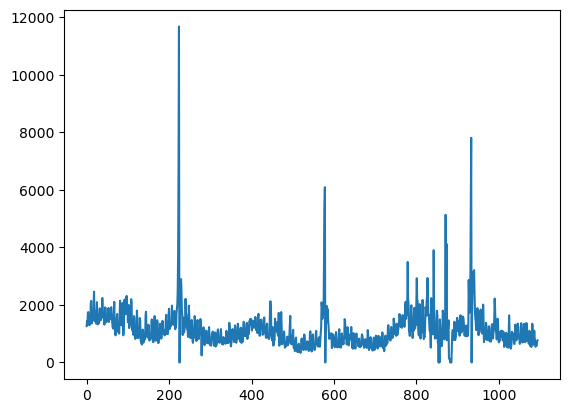

In [156]:
ff_df.target.plot()

In [157]:
ff_df

,date,Aquatic Tuberous Vegetables,Cabbage,Capsicum,Edible Mushroom,Flower/Leaf Vegetables,Solanum,date_sin,date_cos,target
0,2020-07-01,4.850,47.076,76.715,35.365,205.402,35.374,-0.008607,-0.999963,1263.08178
1,2020-07-02,4.600,43.943,66.064,48.510,198.362,32.199,-0.025818,-0.999667,1442.64947
2,2020-07-03,9.572,42.076,64.253,42.442,191.779,35.896,-0.043022,-0.999074,1327.29936
3,2020-07-04,5.439,55.662,81.282,47.262,236.587,57.067,-0.060213,-0.998186,1734.99841
4,2020-07-05,4.019,55.474,98.496,73.213,223.899,61.816,-0.077386,-0.997001,1752.61864
...,...,...,...,...,...,...,...,...,...,...
1090,2023-06-26,10.384,8.083,72.185,39.582,80.524,21.224,0.094537,-0.995521,569.01112
1091,2023-06-27,16.454,14.272,67.120,38.708,127.278,8.415,0.077386,-0.997001,581.94632
1092,2023-06-28,14.946,16.069,68.534,53.742,130.182,15.651,0.060213,-0.998186,582.95046
1093,2023-06-29,22.945,24.367,89.113,48.314,135.090,11.511,0.043022,-0.999074,736.94945


In [158]:
ff_df.to_csv('./data/03_main/modeling.csv')